# Lab Session 6: Word Sense Disambiguation

In this work the following tasks are performed:
- Use of the Lesk algorithm to disambiguate the sense of words in a sentence.
- Replace lemmas by their corresponding synset in a sentence.
- It doesn't improve the global performance of corpus, but it does improve the performance of Machine Translation. ALL metric decreases **(from 0.63 to 0.58 in ALL)**
- Metric in MT corpus keeps similar or slighlty increased: SMTeuroparl from 0.525436 to 0.537500 and SMTnews from 0.409572 to 0.406085

## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr
import spacy
nlp = spacy.load("en_core_web_sm")

from nltk.corpus import wordnet as wn
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import download
import nltk
from nltk.metrics import jaccard_distance

import re
from sklearn.linear_model import RidgeCV

download('averaged_perceptron_tagger')
download('wordnet')
download('omw-1.4')
download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/alberto/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/alberto/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/alberto/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /home/alberto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [26]:
def jaccard_sim(x, y):
    '''
    Returns the Jaccard similarity between two sets
    '''
    return 1 - jaccard_distance(x, y)

class STSAnalyzer:

    def __init__(self, preprocess_fun, name=None, similarity=jaccard_sim, semantic_fun=None):
        self.preprocess_fun = preprocess_fun
        self.name = name
        self.similarity = similarity
        self.semantic_fun = semantic_fun

    def get_similarity(self, x, y):
        '''
        Get the similarity between two strings
        '''
        if self.semantic_fun is not None:
            x_preprep, y_preprep = self.semantic_fun(x, y)
        else:
            x_preprep, y_preprep = x, y
            
        # Clean the sentences and return a set of words
        x_prep = self.preprocess_fun(x_preprep, out_set=True)
        y_prep = self.preprocess_fun(y_preprep, out_set=True)

        # Return the similarity between the two sets of words
        return self.similarity(x_prep, y_prep)
        
    def corr_with_gold(self, filename):
        '''
        Returns the correlation between the gold standard and the similarity
        Input: filename - string with the name of the file
        Output: Pearson correlation object
        '''

        # In some of the files, tabulations appear as \t instead of a tab
        # To solve this problem, it's been included \\t (escaped "\") as a possible separator
        dt = pd.read_csv('../test-gold/STS.input.' + filename, sep='\t|\\t',
                        header=None, on_bad_lines='skip', engine='python')
        dt['gs'] = pd.read_csv('../test-gold/STS.gs.'+ filename, sep='\t|\\t',header=None, 
                            on_bad_lines='skip', engine='python')
        
        # dt.drop_duplicates(subset = [0, 1], keep=False, inplace = True)

        # Bad lines are inserted as null values sometimes 
        # They are counted, informed and removed
        nulls = dt[dt.isnull().any(axis=1)]
        if len(nulls) > 0:
            print(filename, '\n', nulls)
            dt = dt.dropna()

        # Get the similarity between the two sentences
        arr_sim = dt.apply(lambda x: self.get_similarity(*x[:2]) , axis=1).values
        
        return pearsonr(arr_sim, dt['gs'].values)

    def ind_report(self, file, n_show=10):

        print("=====================================================")
        print(file)
        print("=====================================================")
        print("\n")
        df_ind_report = pd.read_csv(f'../test-gold/STS.input.{file}',sep='\t|\\t',header=None, engine='python')
        # df_ind_report.drop_duplicates(subset = [0, 1], keep=False, inplace = True)
        df_ind_report['gs'] = pd.read_csv(f'../test-gold/STS.gs.{file}',sep='\t|\\t',header=None, engine='python')
        df_ind_report['sim'] = df_ind_report.apply(lambda x: self.get_similarity(*x[:2]) , axis=1)
        df_ind_report['sim'] *= 5.
        df_ind_report['dif'] = df_ind_report['sim'] - df_ind_report['gs']

        if n_show is not None:
            difs_tail = df_ind_report.sort_values(by='dif', ascending=False).tail(n_show)
        else:
            difs_tail = df_ind_report.sort_values(by='dif', ascending=False)
            
        for idx, row in difs_tail.iterrows():
            x, y = row[0], row[1]
            prep_x, prep_y = self.preprocess_fun(x, out_set=True), self.preprocess_fun(y, out_set=True)
            print(f"RAW TEXT (DIFFERENCE {row['dif']:.2f})")
            print(x, '\n', y)
            print("\nPREPROCESSED TEXT")
            print(prep_x, '\n', prep_y)
            print("INTERSECTION", prep_x.intersection(prep_y))
            print("DIFFERENCE", prep_x.difference(prep_y).union(prep_y.difference(prep_x)))
            print('\n\n')

            if self.semantic_fun is not None:
                print("SEMANTICAL MODIFICATION\n")
                x, y = self.semantic_fun(row[0], row[1])
                prep_x, prep_y = self.preprocess_fun(x, out_set=True), self.preprocess_fun(y, out_set=True)
                print(f"RAW TEXT (DIFFERENCE {row['dif']:.2f})")
                print(x, '\n', y)
                print("\nPREPROCESSED TEXT")
                print(prep_x, '\n', prep_y)
                print("INTERSECTION", prep_x.intersection(prep_y))
                print("DIFFERENCE", prep_x.difference(prep_y).union(prep_y.difference(prep_x)))
                print('\n\n')

        fig, ax = plt.subplots(1, 2, figsize=(10,2.5))
        plt.suptitle(file)
        df_ind_report.dif.plot.hist(bins=20, title="Residuals", ax=ax[0])
        df_ind_report.dif.plot.box(title="Residuals", ax=ax[1]);
        
        self.df_ind_report = df_ind_report

    def corr_table(self, ls_files):
        
        df_scores = pd.DataFrame(columns=['file','pearson','p_value', 'conf_low', 'conf_high'])

        ls_corr = []
        ls_p_value = []
        ls_conf_low, ls_conf_high = [], []

        for file in ls_files:
            print(f"Processing {file}")
            pearson_stats = self.corr_with_gold(file)
            ls_corr.append(pearson_stats.statistic)
            ls_p_value.append(pearson_stats.pvalue)
            ls_conf_low.append(pearson_stats.confidence_interval(.95).low)
            ls_conf_high.append(pearson_stats.confidence_interval(.95).high)

        df_scores['file'] = ls_files
        df_scores['pearson'] = ls_corr
        df_scores['p_value'] = ls_p_value
        df_scores['conf_low'] = ls_conf_low
        df_scores['conf_high'] = ls_conf_high
        
        if self.name is not None:
            df_scores['name'] = self.name

        self.df_scores = df_scores
        return df_scores
    
    def col_report(self, ls_files, n_show=10):

        # pool = mp.Pool(processes=len(ls_files))  # Use all available CPU cores

        # # Use the pool to parallelize the execution of self.ind_report for each file
        # results = pool.map(self.ind_report, ls_files)

        # # Close the pool and wait for all processes to finish
        # pool.close()
        # pool.join()
        # print(results)
        # # Concatenate the results into a single DataFrame
        # df_col_analysis = pd.DataFrame()
        # for file, df_ind in zip(ls_files, results):
        #     df_ind['file'] = file
        #     df_col_analysis = pd.concat([df_col_analysis, df_ind], axis=0)

        df_col_analysis = pd.DataFrame()
        for file in ls_files:
            self.ind_report(file, n_show=n_show)
            df_ind = self.df_ind_report
            df_ind['file'] = file
            df_col_analysis = pd.concat([df_col_analysis, df_ind], axis=0)
        
        # Pearson correlation for the concatenation of all five datasets
        self.total_corr = pearsonr(df_col_analysis['sim'].values, df_col_analysis['gs'].values)

        # Autoscaled correlation (ALLNORM)
        reg = RidgeCV(alphas=np.logspace(-6, 6, 13), cv=3)
        arr_preds = np.concatenate(df_col_analysis.groupby('file').\
                                    apply(lambda x: reg.fit(x.sim.values.reshape(-1, 1), x.gs.values).predict(x.sim.values.reshape(-1, 1))).values)
        self.allnorm = pearsonr(arr_preds, df_col_analysis['gs'].values)
        
        # Weighted mean correlation (WMEAN)
        self.w_mean = df_col_analysis.groupby('file').\
                        apply(lambda x: pearsonr(x.sim.values, x.gs.values).statistic * x.shape[0] / df_col_analysis.shape[0]).sum()
        
        # Weighted mean of the Pearson correlations on individual datasets
        df_global_scores = pd.DataFrame(columns=['all', 'allnorm', 'wmean'])
        df_global_scores.loc[0] = [self.total_corr[0], self.allnorm[0], self.w_mean]
        if self.name is not None:
            df_global_scores['name'] = self.name
        self.df_global_scores = df_global_scores

        self.df_col_analysis = df_col_analysis

        return df_global_scores
    
    def plot_col_analysis(self, ls_sts=[]):
        df_scores_comp = self.df_scores.copy()
        df_global_scores_comp = self.df_global_scores.copy()

        if ls_sts != []:
            for sts in ls_sts:
                df_scores_comp = pd.concat([df_scores_comp, sts.df_scores], 
                                             axis=0, ignore_index=True)
                df_global_scores_comp = pd.concat([df_global_scores_comp, sts.df_global_scores],
                                                     axis=0, ignore_index=True)
                
        plt.figure(figsize=(10,5))
        sns.barplot(x='file', y='pearson', hue='name', data=df_scores_comp)
        plt.title('Pearson correlation between similarity and gold standard for different preprocessings')
        plt.xticks(rotation=45)

        df_global_comp_plot = df_global_scores_comp.melt(id_vars='name', value_vars=['all', 'allnorm', 'wmean'])
        plt.figure(figsize=(10,5))
        sns.lineplot(x="variable", y="value", hue="name", data=df_global_comp_plot, marker='o')
        plt.ylim(0.5, 1.);
        
                        

# Spacy Baseline

MSRpar.txt


RAW TEXT (DIFFERENCE -3.64)
Sendmail said the system can even be set up to permit business-only usage. 
 The product can be instructed to permit business-only use, according to Sendmail.

PREPROCESSED TEXT
{'sendmail', 'busi', 'system', 'permit', 'say', 'usag', 'set'} 
 {'sendmail', 'product', 'busi', 'instruct', 'permit', 'use', 'accord'}
INTERSECTION {'sendmail', 'permit', 'busi'}
DIFFERENCE {'product', 'system', 'say', 'usag', 'instruct', 'set', 'use', 'accord'}



MSRvid.txt


RAW TEXT (DIFFERENCE -4.00)
A band is performing on a stage. 
 A band is playing onstage.

PREPROCESSED TEXT
{'stage', 'band', 'perform'} 
 {'onstag', 'play', 'band'}
INTERSECTION {'band'}
DIFFERENCE {'stage', 'play', 'onstag', 'perform'}



SMTeuroparl.txt


RAW TEXT (DIFFERENCE -4.50)
There must be a balance as a whole. 
 Group must be in equilibrium.

PREPROCESSED TEXT
{'balanc'} 
 {'equilibrium', 'group'}
INTERSECTION set()
DIFFERENCE {'equilibrium', 'group', 'balanc'}



surprise.OnWN.txt




,file,pearson,p_value,conf_low,conf_high,name
0,MSRpar.txt,0.595611,3.362127e-73,0.547361,0.639914,Lemma+Porter+Clean
1,MSRvid.txt,0.786032,2.117405e-158,0.757043,0.811933,Lemma+Porter+Clean
2,SMTeuroparl.txt,0.525436,6.132524e-34,0.455831,0.588654,Lemma+Porter+Clean
3,surprise.OnWN.txt,0.651277,1.005897e-91,0.608038,0.690664,Lemma+Porter+Clean
4,surprise.SMTnews.txt,0.409572,1.429425e-17,0.324443,0.488120,Lemma+Porter+Clean


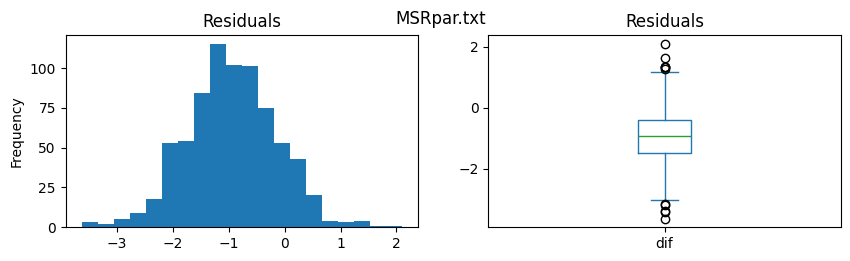

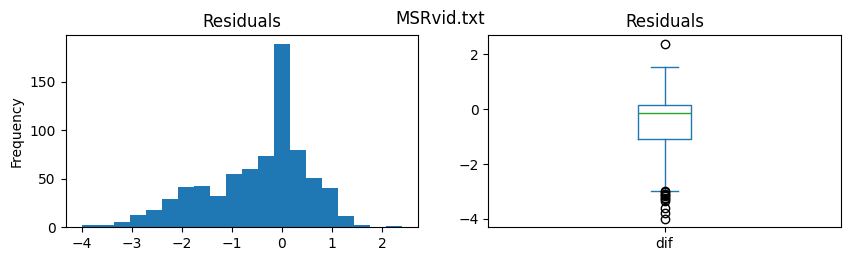

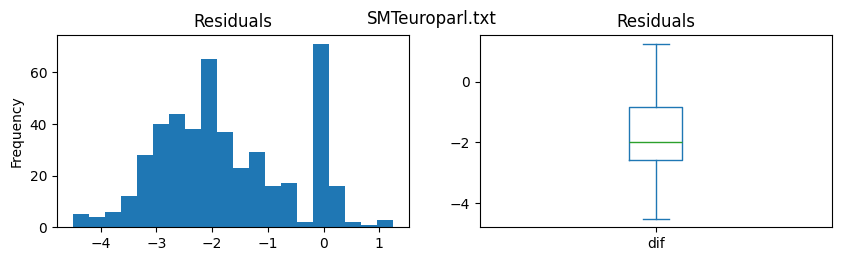

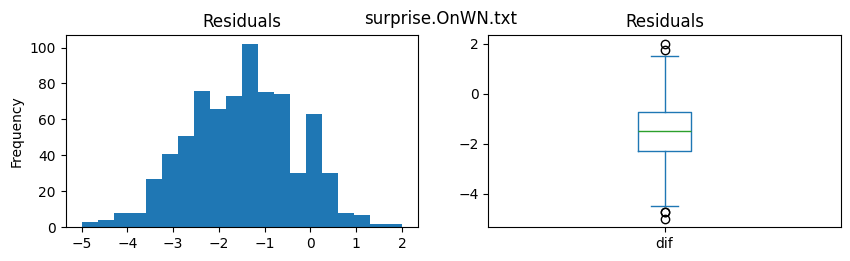

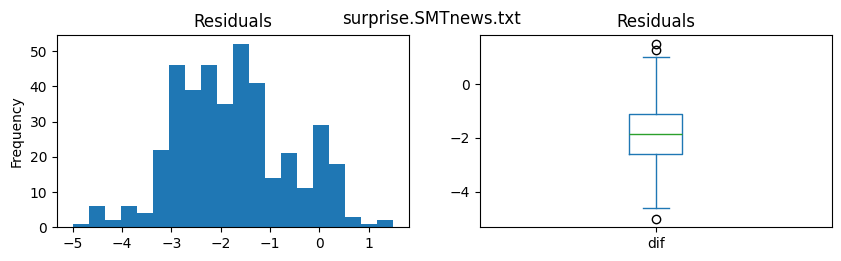

In [27]:
def clean_text(text):

    # Standardize the hours (1pm -> 13:00)
    def convert_to_24_hour(match):
        '''
        Function to convert time to 24 hour format
        Input: match - match object
        Output: string with the time in 24 hour format
        '''
        time_str = match.groups()
        hour, minute, am_pm = time_str[0], '' if time_str[1] is None else time_str[1] ,  re.sub('\.', '', '' if time_str[2] is None else time_str[2])
        # print(time_str)
        if am_pm == 'pm':
            if minute == '':
                return str(int(hour) + 12) + ':00'
            else:
                return str(int(hour) + 12) + ':' + minute
        elif am_pm == 'am':
            if hour == '12':
                return "00" + ':' + minute
            elif minute == '':
                return hour + ':00'
            else:
                return hour + ':' + minute
        else:
            if minute == '':
                return hour + ':00'
            else:
                return hour + ':' + minute

    hour_pattern_1 = re.compile(r'(?<=\s)(\d+)\s?()([ap]\.?m\.?)')
    hour_pattern_2 = re.compile(r'(\d+)[:\.](\d+)\s?([ap]\.?m\.?)')
    hour_pattern_3 = re.compile(r'(\d+)\s?[h:]\s?(\d+)\s?([ap]\.?m\.?)?')
    ls_patterns = [hour_pattern_1, hour_pattern_2, hour_pattern_3]
    for pat in ls_patterns:
        text = re.sub(pat, convert_to_24_hour, text)

    # Delete rests of abbreviated particles
    particle_pattern = re.compile(r"\b(?:'s|'d|'ll|'m|'re|'ve)\b", re.IGNORECASE)
    formatted_text = re.sub(particle_pattern, '', text)

    # Delete rests of abbreviated words to refer people
    mr_ms_pattern = re.compile(r"\b(mr.|mr|ms|ms.|mss.)\b", re.IGNORECASE)
    formatted_text = re.sub(mr_ms_pattern, '', formatted_text)

    # Convert indexes to a single word
    idx_pattern = re.compile(r'<\W*(\w+)=*(\w*)>', re.IGNORECASE)
    formatted_text = re.sub(idx_pattern, r'\1\2', formatted_text)
    
    # Remove the point from words starting with it
    start_point_pattern = re.compile(r'(\W)\.(\w+)', re.IGNORECASE)
    formatted_text = re.sub(start_point_pattern, r'\2', formatted_text)

    # Remove the comma from thousands (standardize)
    thousands_pattern = re.compile(r'(\d+),(\d+)', re.IGNORECASE)
    formatted_text = re.sub(thousands_pattern, r'\1\2', formatted_text)

    # Transform percentages to a single word
    percent_pattern = re.compile(r'(\d+)\s*per\s*cent', re.IGNORECASE)
    formatted_text = re.sub(percent_pattern, r'\1_%', formatted_text)
    
    # Remove the dollar sign from money
    money_pattern = re.compile(r'\$', re.IGNORECASE)
    formatted_text = re.sub(money_pattern, '' , formatted_text)

    return formatted_text

def spacy_preprocess_reviews(text, sw_lang='english', out_set=False, clean_func=None):
    '''
    Function to preprocess the text - remove punctuations, convert to lowercase, remove stopwords
    Input: text - string
    Output: ls_processed_text - list of words
    '''
    if clean_func is not None:
        text = clean_func(text)

    doc = nlp(text)
    ls_processed_text = [w.text.lower() for w in doc if not w.is_stop and not w.is_punct]
    if out_set:
        # For distance metrics, usually, it's needed a set of words
        return set(ls_processed_text)
    else:
        return ls_processed_text

def spacy_preprocess_lemma_porter(text, sw_lang='english', out_set=False, clean_func=None):
    '''
    Function to preprocess the text - remove punctuations, convert to lowercase, remove stopwords
    Input: text - string
    Output: ls_processed_text - list of words
    '''

    if clean_func is not None:
        text = clean_func(text)
    # text = clean_text(text)
    doc = nlp(text)
    stemmer = PorterStemmer()
    ls_processed_text = [stemmer.stem(w.lemma_.lower()) for w in doc if not w.is_stop and not w.is_punct]

    if out_set:
        # For distance metrics, usually, it's needed a set of words
        return set(ls_processed_text)
    else:
        return ls_processed_text
    
def spacy_preprocess_lemma_porter_clean(x, **kwargs): return spacy_preprocess_lemma_porter(x, clean_func=clean_text, **kwargs)

ls_files = ["MSRpar.txt", "MSRvid.txt", "SMTeuroparl.txt", "surprise.OnWN.txt", "surprise.SMTnews.txt"]

lemma_porter_clean = STSAnalyzer(spacy_preprocess_lemma_porter_clean, name='Lemma+Porter+Clean')
lemma_porter_clean.col_report(ls_files, n_show=1)
lemma_porter_clean.corr_table(ls_files)

In [28]:
lemma_porter_clean.df_global_scores

,all,allnorm,wmean,name
0,0.631572,0.816485,0.620748,Lemma+Porter+Clean


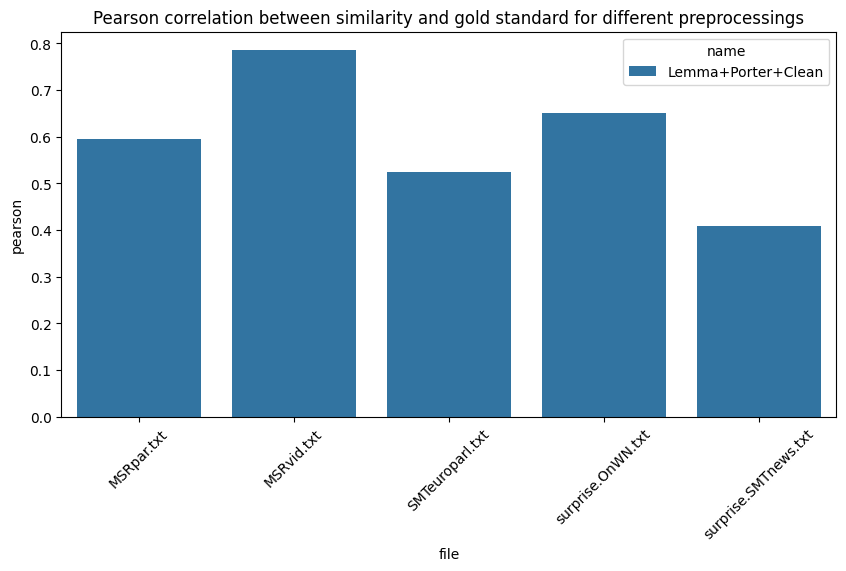

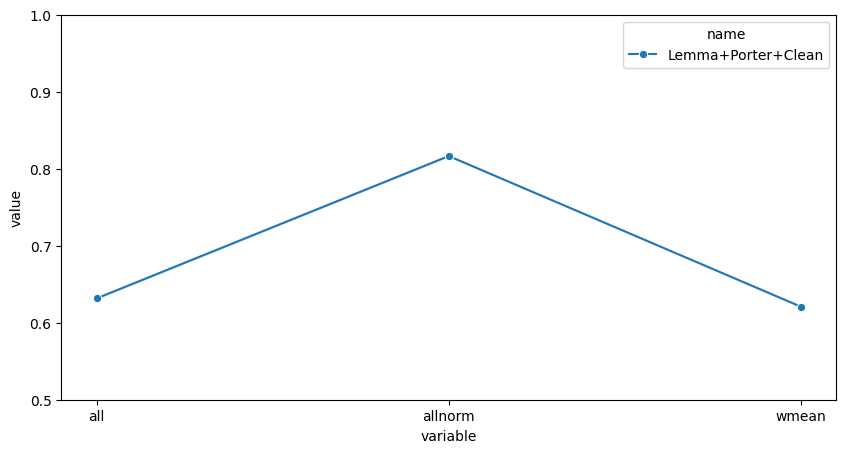

In [29]:
lemma_porter_clean.plot_col_analysis([lemma_porter_clean])

# Using Word Disambiguation

In [65]:
sent = "It would take three votes to kill the ACC's expansion."
[(w.lemma_, w.pos_) for w in nlp(sent) if not w.is_stop and not w.is_punct]

[('vote', 'NOUN'), ('kill', 'VERB'), ('ACC', 'PROPN'), ('expansion', 'NOUN')]

MSRpar.txt


RAW TEXT (DIFFERENCE -3.67)
Three no votes would kill it for now. 
 It would take three votes to kill the ACC's expansion.

PREPROCESSED TEXT
{'vote.n.05', 'toss_off.v.02'} 
 {'vote.n.04', 'kill.v.15', 'expansion.n.03', 'air_combat_command.n.01'}
INTERSECTION set()
DIFFERENCE {'vote.n.05', 'vote.n.04', 'air_combat_command.n.01', 'toss_off.v.02', 'kill.v.15', 'expansion.n.03'}



MSRvid.txt


RAW TEXT (DIFFERENCE -4.00)
The lady sliced a tomatoe. 
 Someone is cutting a tomato.

PREPROCESSED TEXT
{'tomatoe', 'slit.v.01', 'lady.n.03'} 
 {'tomato.n.01', 'switch_off.v.01'}
INTERSECTION set()
DIFFERENCE {'tomato.n.01', 'tomatoe', 'slit.v.01', 'switch_off.v.01', 'lady.n.03'}



SMTeuroparl.txt


RAW TEXT (DIFFERENCE -4.80)
There must be a balance as a whole. 
 All must be balanced.

PREPROCESSED TEXT
{'symmetry.n.01'} 
 {'poise.v.04'}
INTERSECTION set()
DIFFERENCE {'symmetry.n.01', 'poise.v.04'}



surprise.OnWN.txt


RAW TEXT (DIFFERENCE -5.00)
physical matter left behind after 

,file,pearson,p_value,conf_low,conf_high,name
0,MSRpar.txt,0.564959,1.845367e-64,0.514165,0.611803,Lemma+Lesk+Clean
1,MSRvid.txt,0.743556,7.137288e-133,0.709747,0.773947,Lemma+Lesk+Clean
2,SMTeuroparl.txt,0.537500,1.009942e-35,0.469049,0.599533,Lemma+Lesk+Clean
3,surprise.OnWN.txt,0.588495,4.355487e-71,0.539641,0.633399,Lemma+Lesk+Clean
4,surprise.SMTnews.txt,0.406085,2.837221e-17,0.320695,0.484927,Lemma+Lesk+Clean


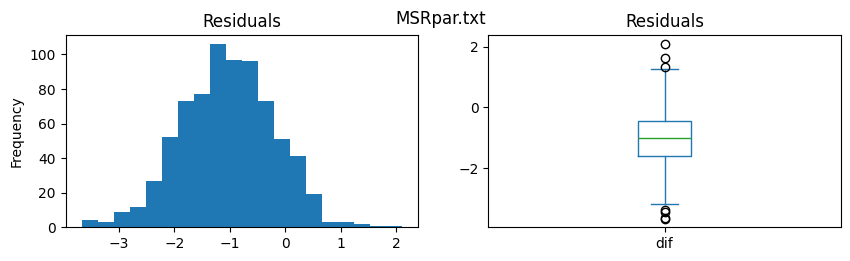

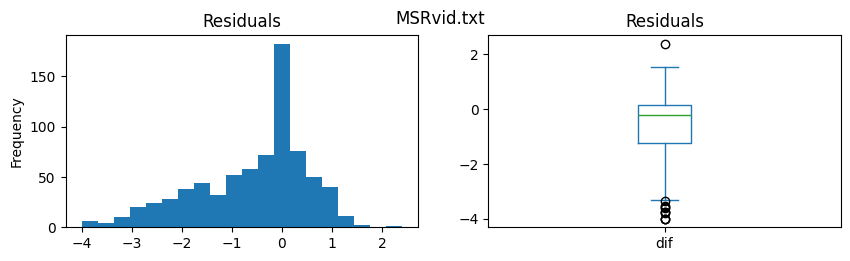

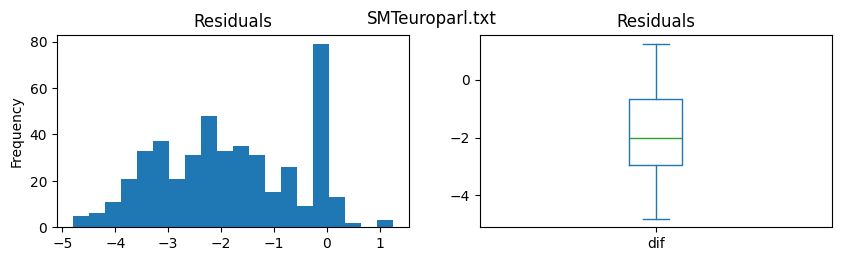

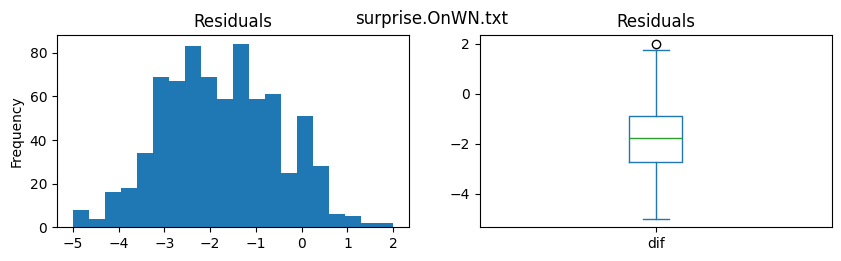

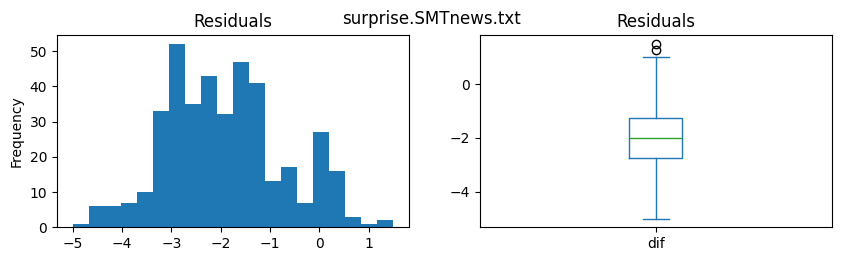

In [59]:
def clean_text(text):

    # Standardize the hours (1pm -> 13:00)
    def convert_to_24_hour(match):
        '''
        Function to convert time to 24 hour format
        Input: match - match object
        Output: string with the time in 24 hour format
        '''
        time_str = match.groups()
        hour, minute, am_pm = time_str[0], '' if time_str[1] is None else time_str[1] ,  re.sub('\.', '', '' if time_str[2] is None else time_str[2])
        # print(time_str)
        if am_pm == 'pm':
            if minute == '':
                return str(int(hour) + 12) + ':00'
            else:
                return str(int(hour) + 12) + ':' + minute
        elif am_pm == 'am':
            if hour == '12':
                return "00" + ':' + minute
            elif minute == '':
                return hour + ':00'
            else:
                return hour + ':' + minute
        else:
            if minute == '':
                return hour + ':00'
            else:
                return hour + ':' + minute

    hour_pattern_1 = re.compile(r'(?<=\s)(\d+)\s?()([ap]\.?m\.?)')
    hour_pattern_2 = re.compile(r'(\d+)[:\.](\d+)\s?([ap]\.?m\.?)')
    hour_pattern_3 = re.compile(r'(\d+)\s?[h:]\s?(\d+)\s?([ap]\.?m\.?)?')
    ls_patterns = [hour_pattern_1, hour_pattern_2, hour_pattern_3]
    for pat in ls_patterns:
        text = re.sub(pat, convert_to_24_hour, text)

    # Delete rests of abbreviated particles
    particle_pattern = re.compile(r"\b(?:'s|'d|'ll|'m|'re|'ve)\b", re.IGNORECASE)
    formatted_text = re.sub(particle_pattern, '', text)

    # Delete rests of abbreviated words to refer people
    mr_ms_pattern = re.compile(r"\b(mr.|mr|ms|ms.|mss.)\b", re.IGNORECASE)
    formatted_text = re.sub(mr_ms_pattern, '', formatted_text)

    # Convert indexes to a single word
    idx_pattern = re.compile(r'<\W*(\w+)=*(\w*)>', re.IGNORECASE)
    formatted_text = re.sub(idx_pattern, r'\1\2', formatted_text)
    
    # Remove the point from words starting with it
    start_point_pattern = re.compile(r'(\W)\.(\w+)', re.IGNORECASE)
    formatted_text = re.sub(start_point_pattern, r'\2', formatted_text)

    # Remove the comma from thousands (standardize)
    thousands_pattern = re.compile(r'(\d+),(\d+)', re.IGNORECASE)
    formatted_text = re.sub(thousands_pattern, r'\1\2', formatted_text)

    # Transform percentages to a single word
    percent_pattern = re.compile(r'(\d+)\s*per\s*cent', re.IGNORECASE)
    formatted_text = re.sub(percent_pattern, r'\1_%', formatted_text)
    
    # Remove the dollar sign from money
    money_pattern = re.compile(r'\$', re.IGNORECASE)
    formatted_text = re.sub(money_pattern, '' , formatted_text)

    return formatted_text


def spacy_preprocess_lemma_lesk(text, sw_lang='english', out_set=False, clean_func=None):
    '''
    Function to preprocess the text - remove punctuations, convert to lowercase, remove stopwords
    Input: text - string
    Output: ls_processed_text - list of words
    '''

    spacy_to_wordnet_pos = {
                            "ADJ": "a",    # Adjective
                            "NOUN": "n",   # Noun
                            "PROPN": "n",  # Proper noun -
                            "VERB": "v",   # Verb -
                            "ADV": "r",    # Adverb
                            "NUM": "n",    # Numeral
                            "PRON": "n",   # Pronoun
                            "ADP": "n",    # Adposition (preposition or postposition)
                        }
    
    if clean_func is not None:
        text = clean_func(text)

    # text = clean_text(text)
    doc = nlp(text)

    ########## DISAMBIGUATION WITH LESK ##########
    # Get the lemma and the POS tag
    ls_processed_text = [(w.lemma_.lower(), w.pos_) for w in doc 
                            if not w.is_stop and not w.is_punct]
    # Convert the POS tag to the WordNet POS tag
    ls_processed_text = [(lemma, spacy_to_wordnet_pos.get(pos, 'n')) 
                         for lemma, pos in ls_processed_text]

    # Instead of using the original text for disambiguation, we use only the lemmas
    text = ' '.join([lemma for lemma, _ in ls_processed_text])

    ls_disamb = []
    for lemma, pos in ls_processed_text:
        # If it has a disambiguation synset, get it
        get_disamb = nltk.wsd.lesk(text, lemma, pos)

        # Otherwise, get the first synset
        if get_disamb is None:
            try:
                get_disamb = wn.synsets(lemma, pos)[0].name()
            except IndexError:
                get_disamb = lemma
        # If there isn't a first sentence, get the lemma
        else:
            get_disamb = get_disamb.name()

        ls_disamb.append(get_disamb)
        
    ##################################################  
    ls_processed_text = ls_disamb

    if out_set:
        # For distance metrics, usually, it's needed a set of words
        return set(ls_processed_text)
    else:
        return ls_processed_text


def spacy_preprocess_lemma_lesk_clean(x, **kwargs): return spacy_preprocess_lemma_lesk(x, clean_func=clean_text, **kwargs)

ls_files = ["MSRpar.txt", "MSRvid.txt", "SMTeuroparl.txt", "surprise.OnWN.txt", "surprise.SMTnews.txt"]

lemma_lesk_clean = STSAnalyzer(spacy_preprocess_lemma_lesk_clean, name='Lemma+Lesk+Clean')
lemma_lesk_clean.col_report(ls_files, n_show=1)
lemma_lesk_clean.corr_table(ls_files)

In [63]:
lemma_porter_clean.df_global_scores

,all,allnorm,wmean,name
0,0.631572,0.816485,0.620748,Lemma+Porter+Clean


In [61]:
lemma_lesk_clean.df_global_scores

,all,allnorm,wmean,name
0,0.58027,0.793842,0.589285,Lemma+Lesk+Clean


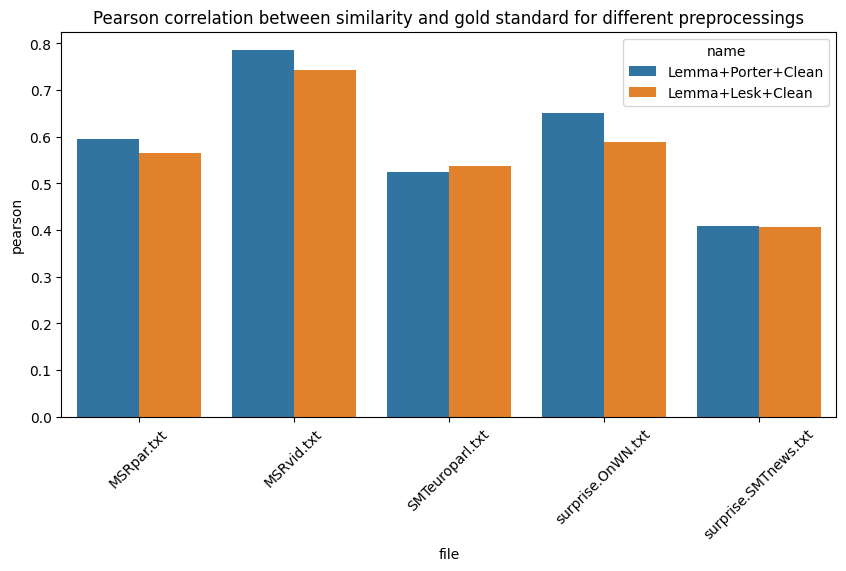

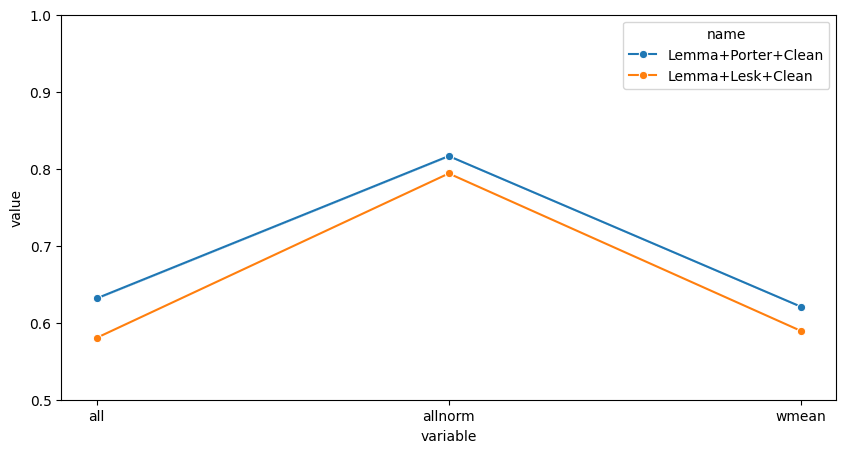

In [60]:
lemma_porter_clean.plot_col_analysis([lemma_porter_clean, lemma_lesk_clean])

# Results and Conclussions

No improvement is achieved in general. The only improvement is in the SMT corpus, but it is not significant.

- It doesn't improve the global performance of corpus, but it does improve the performance of Machine Translation. ALL metric decreases **(from 0.63 to 0.58 in ALL)**
- Metric in MT corpus keeps similar or slighlty increased: SMTeuroparl from 0.525436 to 0.537500 and SMTnews from 0.409572 to 0.406085

The reasons can be the following:
- Using jaccard distance, the addition of pos tags does not improve the results because it considers, for example, no similarity between "remove" and "removal". One is verb and the other is noun, but they are related and this is quite common in Paraphrasing. It is not that common in MT.

    Example:
    ```
    RAW TEXT (DIFFERENCE -5.00)
    physical matter left behind after a removal process 
    matter that remains after something has been removed.

    PREPROCESSED TEXT
    {'summons.n.03', 'physical.a.02', 'removal.n.02', 'leave.v.11', 'matter.n.04'} 
    {'stay.v.04', 'remove.v.02', 'matter'}
    INTERSECTION set()
    DIFFERENCE {'stay.v.04', 'summons.n.03', 'removal.n.02', 'leave.v.11', 'remove.v.02', 'matter.n.04', 'matter', 'physical.a.02'}
    ```
- Lesk may not be the best algorithm to disambiguate words for our purposes.



# Further Work
- Try to find a way to combine stemming and word disambiguation.


# Appendix: Textserver

In [2]:
import getpass
from textserver import TextServer



In [3]:
path = '../test-gold/'

p_input_europarl = 'STS.input.SMTeuroparl.txt'
p_gs_europarl = 'STS.gs.SMTeuroparl.txt'

def create_df(preprocessing_function=None, random_state=0):
    np.random.seed(random_state)
    df = pd.read_csv(path + p_input_europarl, sep='\t', header=None) 
    df = df.sample(10)
    if preprocessing_function is not None:   
        df[2] = df.apply(lambda col: preprocessing_function(col[0]), axis=1)
        df[3] = df.apply(lambda col: preprocessing_function(col[1]), axis=1)
        df['gs'] = pd.read_csv(path + p_gs_europarl, sep='\t', header=None)
        df['jaccard'] = df.apply(lambda col: 5*(1 - jaccard_distance(col[2], col[3])), axis=1)
    df['gs'] = pd.read_csv(path + p_gs_europarl, sep='\t', header=None)
    
    # Extract 10 random rows
    
    return df


df = create_df()

df

,0,1,gs
164,"Unanimous decisions, and hence an inherent inc...",We keep unanimity in the Council and therefore...,4.167
229,We often pontificate here about being the repr...,We we pride often here of representing the Eur...,4.250
311,The European Union has got to do something and...,It is important that the European Union to be ...,5.000
221,"The standards are scarcely comparable, let alo...",Norms are barely comparable and even less alie...,3.250
122,Maij-Weggen report (A5-0323/2000),Maij-Weggen report (5 / 2000),3.000
253,(Parliament adopted the legislative resolution),", The Parliament adopted the legislative resol...",5.000
309,Amendment No 7 proposes certain changes in the...,The amendment 7 proposes some modifications in...,5.000
12,(Parliament adopted the legislative resolution),(The Parliament adopts legislative resolution),4.750
219,There must be a balance as a whole.,The unit must be in balance.,4.750
96,Neither was there a qualified majority within ...,There was no qualified majority in this Parlia...,5.000


## Lesk Algorithm

In [4]:
pos_tags = {'NN': wn.NOUN,
        'VB': wn.VERB,
        'JJ': wn.ADJ, 
        'RB': wn.ADV}

# Stopwords
sw = set(nltk.corpus.stopwords.words('english')) 

def apply_lesk_algorithm_sw(sentence):
  # Get the POS tag of each word in the sentence
  pairs = nltk.pos_tag(nltk.word_tokenize(sentence))

  # Get the synset of each word in the sentence using the POS tag and the Lesk algorithm
  synsets = set(nltk.wsd.lesk(sentence, pair[0], pos_tags.get(pair[1][:2].upper())) for pair in pairs if pair[0] not in sw)

  # Return the set of synsets
  return set(syn.name() for syn in synsets if syn)

df = create_df(apply_lesk_algorithm_sw)

corrcoef = pearsonr(df['gs'], df['jaccard'])[0]
print(f"The correlation using the Lesk algorithm is {corrcoef:.4f}")

df

The correlation using the Lesk algorithm is 0.4185


,0,1,2,3,gs,jaccard
164,"Unanimous decisions, and hence an inherent inc...",We keep unanimity in the Council and therefore...,"{council.n.03, incapacity.n.02, therefore.r.01...","{inability.n.02, council.n.03, retain.v.02, th...",4.167,1.363636
229,We often pontificate here about being the repr...,We we pride often here of representing the Eur...,"{representative.n.01, citizen.n.01, often.r.03...","{pride.v.01, citizen.n.01, often.r.03, typify....",4.250,1.250000
311,The European Union has got to do something and...,It is important that the European Union to be ...,"{union.n.11, quickly.r.01, european.n.01, rece...","{quickly.r.01, european.n.01, union.n.11, info...",5.000,2.142857
221,"The standards are scarcely comparable, let alo...",Norms are barely comparable and even less alie...,"{let.v.01, comparable.a.01, entirely.r.02, sta...","{less.r.02, scantily.r.01, comparable.a.01, al...",3.250,0.500000
122,Maij-Weggen report (A5-0323/2000),Maij-Weggen report (5 / 2000),{reputation.n.03},"{reputation.n.03, five.s.01}",3.000,2.500000
253,(Parliament adopted the legislative resolution),", The Parliament adopted the legislative resol...","{solution.n.02, legislative.a.01, assume.v.03,...","{solution.n.02, legislative.a.01, assume.v.03,...",5.000,5.000000
309,Amendment No 7 proposes certain changes in the...,The amendment 7 proposes some modifications in...,"{reference_book.n.01, nobelium.n.01, paragraph...","{reference_book.n.01, modification.n.03, propo...",5.000,2.000000
12,(Parliament adopted the legislative resolution),(The Parliament adopts legislative resolution),"{solution.n.02, legislative.a.01, assume.v.03,...","{solution.n.02, legislative.a.01, parliament.n...",4.750,3.750000
219,There must be a balance as a whole.,The unit must be in balance.,"{there.n.01, symmetry.n.01, must.n.01, whole.n...","{must.n.01, symmetry.n.01, whole.n.02}",4.750,3.750000
96,Neither was there a qualified majority within ...,There was no qualified majority in this Parlia...,"{revert.v.02, article.n.04, neither.s.01, qual...","{article.n.04, sound.v.02, there.n.01, back.r....",5.000,1.363636


In [5]:
user = input("Introduce your username:")
# introduce password
pwd = getpass.getpass("Introduce your password:")
ts = TextServer(user=user, pwd=pwd, service='senses')

def apply_senses_algorithm(sentence):
  
  feats = ts.senses(sentence)[0]
  synsets = set()
  for word in feats:
    synsets.add(word[-1])

  # Return the set of synsets
  return set(syn for syn in synsets if syn)
  
df = create_df(apply_senses_algorithm)
df.head()

,0,1,2,3,gs,jaccard
164,"Unanimous decisions, and hence an inherent inc...",We keep unanimity in the Council and therefore...,"{08310949-n, 13854488-n, 00043003-r, N/A, 0134...","{05644922-n, 08310949-n, 02202384-v, 00043003-...",4.167,1.333333
229,We often pontificate here about being the repr...,We we pride often here of representing the Eur...,"{02432395-v, 02604760-v, N/A, 00108479-r, 0992...","{09686536-n, N/A, 00108479-r, 09923673-n, 0003...",4.250,1.818182
311,The European Union has got to do something and...,It is important that the European Union to be ...,"{N/A, 01712704-v, 00065639-v, 08173515-n, 0008...","{01275562-a, 02604760-v, N/A, 01712704-v, 0817...",5.000,2.500000
221,"The standards are scarcely comparable, let alo...",Norms are barely comparable and even less alie...,"{07260623-n, N/A, 02604760-v, 00003093-r, 0080...","{13854488-n, 02604760-v, N/A, 00017445-r, 0007...",3.250,1.250000
122,Maij-Weggen report (A5-0323/2000),Maij-Weggen report (5 / 2000),"{N/A, 06681551-n}","{N/A, 06681551-n}",3.000,5.000000


In [6]:
corrcoef = pearsonr(df['gs'], df['jaccard'])[0]
print(f"The correlation using the UKB algorithm is {corrcoef:.4f}")

df

The correlation using the URB algorithm is 0.2121


,0,1,2,3,gs,jaccard
164,"Unanimous decisions, and hence an inherent inc...",We keep unanimity in the Council and therefore...,"{08310949-n, 13854488-n, 00043003-r, N/A, 0134...","{05644922-n, 08310949-n, 02202384-v, 00043003-...",4.167,1.333333
229,We often pontificate here about being the repr...,We we pride often here of representing the Eur...,"{02432395-v, 02604760-v, N/A, 00108479-r, 0992...","{09686536-n, N/A, 00108479-r, 09923673-n, 0003...",4.250,1.818182
311,The European Union has got to do something and...,It is important that the European Union to be ...,"{N/A, 01712704-v, 00065639-v, 08173515-n, 0008...","{01275562-a, 02604760-v, N/A, 01712704-v, 0817...",5.000,2.500000
221,"The standards are scarcely comparable, let alo...",Norms are barely comparable and even less alie...,"{07260623-n, N/A, 02604760-v, 00003093-r, 0080...","{13854488-n, 02604760-v, N/A, 00017445-r, 0007...",3.250,1.250000
122,Maij-Weggen report (A5-0323/2000),Maij-Weggen report (5 / 2000),"{N/A, 06681551-n}","{N/A, 06681551-n}",3.000,5.000000
253,(Parliament adopted the legislative resolution),", The Parliament adopted the legislative resol...","{N/A, 02829565-a, 04861486-n, 00601822-v, 0831...","{N/A, 02829565-a, 04861486-n, 00601822-v, 0831...",5.000,5.000000
309,Amendment No 7 proposes certain changes in the...,The amendment 7 proposes some modifications in...,"{07296428-n, N/A, 00875394-v, 00340239-a, 0672...","{07296428-n, N/A, 00875394-v, 06723635-n, 0725...",5.000,4.285714
12,(Parliament adopted the legislative resolution),(The Parliament adopts legislative resolution),"{N/A, 02829565-a, 04861486-n, 00601822-v, 0831...","{N/A, 02829565-a, 04861486-n, 00601822-v, 0831...",4.750,5.000000
219,There must be a balance as a whole.,The unit must be in balance.,"{N/A, 13897996-n, 00003553-n, 02604760-v}","{N/A, 13897996-n, 00003553-n, 02604760-v}",4.750,5.000000
96,Neither was there a qualified majority within ...,There was no qualified majority in this Parlia...,"{04417809-n, 02604760-v, N/A, 05122557-n, 0002...","{00075367-r, 02618149-v, 02604760-v, N/A, 0512...",5.000,2.272727
